Este notebook lo usamos para sacar los datos de los recorridos que (por desgracia) se tienen que sacar a mano.

Cosas que pongo aquí porque si no se me olvidan:

* Los carriles se enumeran desde 0 (el derecho) hasta n (el más izquiero de todos). Eso quiere decir que los cambios son -1 a la derecha y +1 a la izquierda.
* Si el siguiente semáforo está muy lejos, nos da exactamente igual el estado en el que esté. Este hecho lo podemos usar para generar más datos.
* La precisión del GPS es un poco chusta, así que los resultados mejorarían dramáticamente en el caso de conseguir una mayor precisión en la toma de datos.

In [42]:
%matplotlib notebook

import os

import pandas as pd
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pynsia.pointcloud import PointCloud, transformation_matrix
from sklearn.cluster import DBSCAN

import ipywidgets as widgets
from IPython.display import display

from pynsia import latlon

from utils import load_master_df, load_subject_df, DATASETS_INFO

figsize = (8, 4)

In [68]:
# BASE_PATH = '/home/blazaid/Projects/data-phd/sync'
BASE_PATH = '/media/blazaid/Saca/Phd/data/sync'
SUBJECT = 'miguel'  # edgar, jj, miguel
DATASET = 'validation'  # training, validation

In [69]:
# Load the subject's data
df = load_subject_df(BASE_PATH, SUBJECT, DATASET, 'dataset')
# Select user info
dataset_info = DATASETS_INFO[SUBJECT][DATASET]
# Subject's path
SUBJECT_PATH = os.path.join(BASE_PATH, SUBJECT, DATASET)
# Calibration data
calibration_data = dataset_info['calibration_data']

## Subconjuntos de entrenamiento y test

De los conjuntos sincronizados originales extraeremos unos subconjuntos similares para trabajar con ellos, de tal manera que para cada sujeto los comienzos y los finales de las rutas sean aproximadamente los mismos.

Estos datos se han sacado visualizando los vídeos de los sujetos.

In [70]:
starting_frame = dataset_info['starting_frame'] or 0
ending_frame = dataset_info['ending_frame'] or (len(df) - 1)

print('Starting frame:\t{}'.format(starting_frame))
print('Ending frame:\t{}'.format(ending_frame))
print('New route len:\t{}'.format(ending_frame + 1 - starting_frame))
df = df[starting_frame:ending_frame + 1].reset_index(drop=True)

Starting frame:	44
Ending frame:	3651
New route len:	3608


<IPython.core.display.Javascript object>


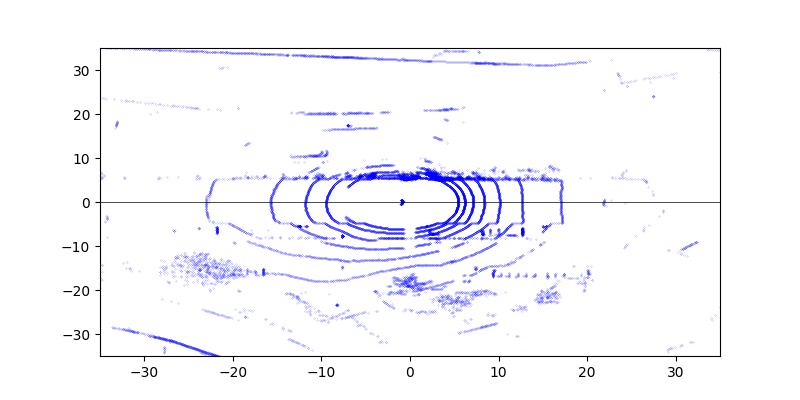

In [71]:
for index, row in df.iterrows():
    ps = PointCloud.load(row['pointclouds_path']).transform(**calibration_data).points
    break

fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_xlim((-35, 35))
ax.set_ylim((-35, 35))
#ax.set_aspect('equal', adjustable='box')
#ps = pc.transform(rot_x=0, rot_y=3, rot_z=-3.1,
#    shift_x=0,
#    shift_y=-10,
#    shift_z=0
#).points
ax.scatter(ps[:,0], ps[:,1], s=.01, color='b');
ax.plot([-35, 35], [0, 0], color='0', linewidth=0.5);

## Cambios de carril

El cálculo de los cambios de carril (desgraciadamente) se hace a mano. Está definido en la variable DATASETS_INFO para cada conductor y dataset, y se ha obtenido mediante la visualización de los vídeos.

<IPython.core.display.Javascript object>


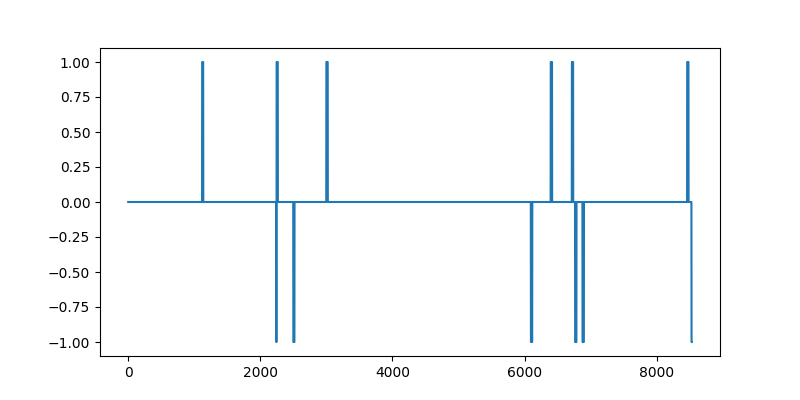

In [6]:
df['Lane change'] = 0
for ini_frame, end_frame, change in dataset_info['lane_changes']:
    df.loc[ini_frame:end_frame, 'Lane change'] = change
fig, ax = plt.subplots(1, 1, figsize=figsize)
df['Lane change'].plot(ax=ax);

## Velocidad máxima

Como en los cambios de carril, la velocidad máxima se ha extraído manualmente a partir de la información de los mapas de openstreetmap y de los vídeos de los recorridos.

<IPython.core.display.Javascript object>


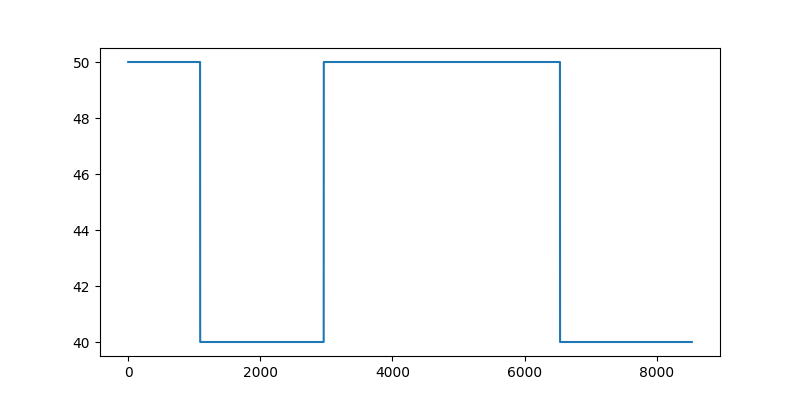

In [7]:
df['Max speed'] = 0
for frame, speed in dataset_info['max_speed']:
    df.loc[frame:, 'Max speed'] = speed
fig, ax = plt.subplots(1, 1, figsize=figsize)
df['Max speed'].plot(ax=ax);

## Distancias

Todas las distancias se calcularán más o menos de la misma manera (salvo la del vehículo delantero). Se tiene una tabla maestra con las posiciones de los puntos de interes contra los que calcular la distancia. A partir de ahí se generan tantas columnas como puntos de interes y tantas filas como filas tiene el recorrido. Después, de forma manual, se irá eligiendo qué punto de interes corresponde a qué intervalo y se generará la nueva tabla con dichos valores.

## Distancias a semáforos

Cada sujeto tiene un fichero con la información de cuál es el siguiente semáforo para cada distancia. Se generará por tanto una columna con las distancias al siguiente semáfolo y su estado.

In [8]:
# Base TLS dataframe
master_tls_df = load_master_df(BASE_PATH, DATASET, 'tls')
master_tls_df = master_tls_df.set_index('tls')
# Subject tls's dataframe
tls_df = load_subject_df(BASE_PATH, SUBJECT, DATASET, 'tls')

<IPython.core.display.Javascript object>


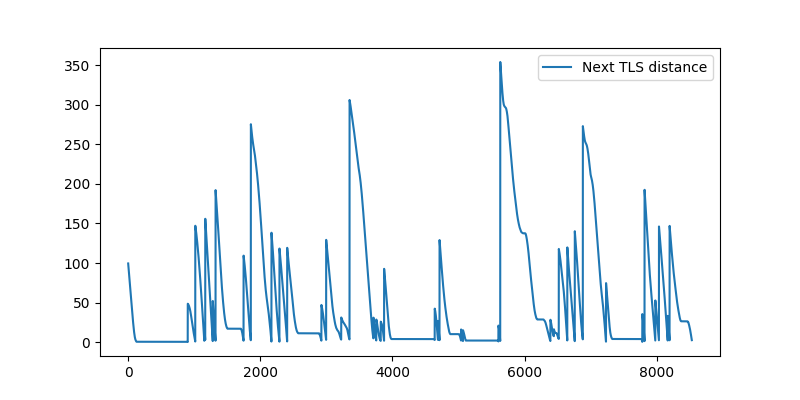

In [9]:
df['Next TLS distance'] = 0.0
df['Next TLS status'] = 0.0
for i, row in tls_df.iterrows():
    next_tls = row['next_tls']
    
    lat, lon = master_tls_df.loc[row['next_tls'],['lat', 'lon']]
    df.loc[row['frame']:,'Next TLS status'] = row['status']
    df.loc[row['frame']:,'Next TLS distance'] = df.loc[row['frame']:,['gps_positions_latitude', 'gps_positions_longitude']].apply(lambda r: latlon.distance(
        (r['gps_positions_latitude'], r['gps_positions_longitude']),
        (lat, lon)
    ), axis=1)

fig, ax = plt.subplots(1, 1, figsize=figsize)
df[['Next TLS distance']].plot(ax=ax);

## Distancias recorribles

En cada momento, el vehículo tendrá noción de cuánta distancia puede recorrer en su carril, el carril de la izquierda y el de la derecha. Se pretende de esta manera que el modelo sea capaz de determinar cambios de carril. Esta información está disponible en SUMO, razón por la que se ha intentado obtener aquí. Ha requerido de bastante trabajo manual.

<IPython.core.display.Javascript object>


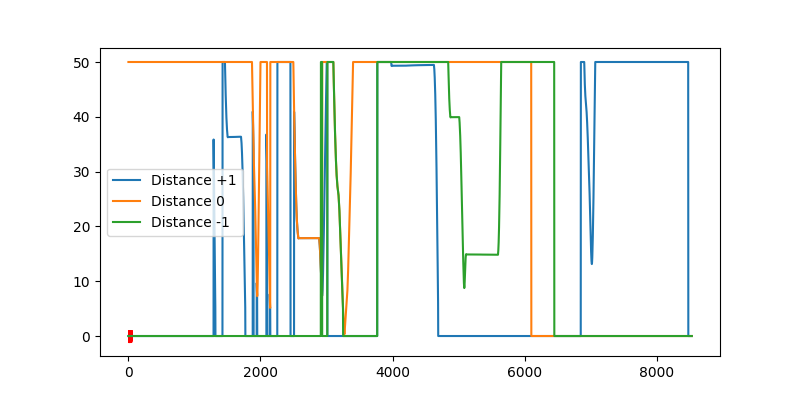

In [10]:
df['Distance +1'] = df['Distance 0'] = df['Distance -1'] = np.inf

for frame, left, current, right in dataset_info['lanes_distances']:
    # Is the same code for each column, so we do this for over all of them
    for lane, column in zip([left, current, right], ['Distance +1', 'Distance 0', 'Distance -1']):
        # Three options, inf (default), tuple (calc. distance) or 0
        if lane != np.inf:
            if isinstance(lane, tuple):
                lat, lon = lane
                df.loc[frame:,column] = df.loc[frame:,['gps_positions_latitude', 'gps_positions_longitude']].apply(
                    lambda r: latlon.distance(
                        (r['gps_positions_latitude'], r['gps_positions_longitude']),
                        (lat, lon)
                    ), axis=1
                )
            else:
                df.loc[frame:,column] = 0
fig, ax = plt.subplots(1, 1, figsize=figsize)
np.minimum(50, df[['Distance +1', 'Distance 0', 'Distance -1']]).plot(ax=ax)

## Distancia al objeto más cercano

Para sacar la distancia al objeto delantero, se usará una porción rectangular de la nube de puntos para detectar clústers y así determinar si el objeto delantero es un obstáculo.

Requiere trabajo manual, pero al menos es mejor que nada.

frames (1440, 1520) ................................................................................
frames (1690, 1830) ............................................................................................................................................
frames (2250, 2375) .............................................................................................................................
frames (2470, 2605) .......................................................................................................................................
frames (3120, 3245) .............................................................................................................................
frames (4810, 4895) .....................................................................................
frames (4990, 5050) ............................................................
frames (6130, 6220) ...................................................................................

<IPython.core.display.Javascript object>


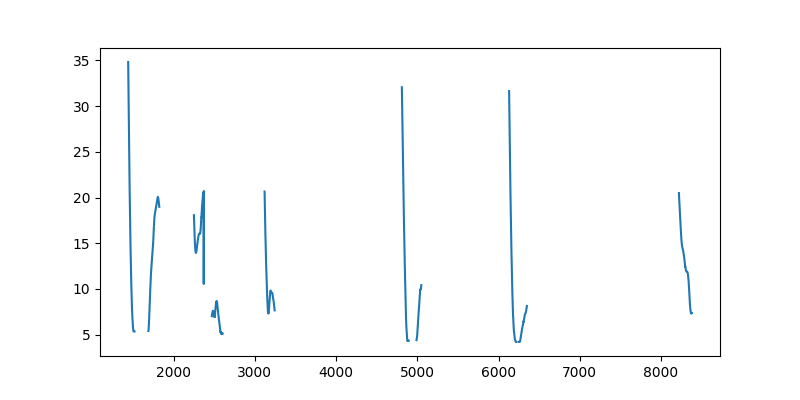

In [37]:
df['Next car distance'] = np.nan
for frame_ini, frame_end, episilon, min_samples in dataset_info['cf_dist']:
    for frame, row in df[frame_ini:frame_end].iterrows():
        pointcloud_path = row['pointclouds_path']
        if not pd.isnull(pointcloud_path):
            ps = PointCloud.load(pointcloud_path).transform(**calibration_data).points

            # Extract the points in the specified bounding box
            mask = (ps[:,2] > -1.5) & (ps[:,2] < 0.5) & (ps[:,0] < 35) & (ps[:,0] > 0.35) & (ps[:,1] < 1) & (ps[:,1] > -1)
            masked_points = ps[mask,:]

            # Look for clusters and extract the distance to them
            n_clusters = 0
            n_points = len(masked_points)
            dist = np.nan
            if len(masked_points) > 0:
                db = DBSCAN(eps=1, min_samples=2).fit(masked_points)
                labels = db.labels_
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                for cluster in range(n_clusters):
                    obs = masked_points[labels == cluster]
                    ax.scatter(obs[:,0], obs[:,1], s=1, color='r', alpha=0.1);
                    centroid_dist = np.sqrt(np.mean(obs[:, 0])**2 + np.mean(obs[:, 1])**2)
                    dist = centroid_dist if pd.isnull(dist) else min(dist, centroid_dist)

            df.loc[frame, 'Next car distance'] = dist

fig, ax = plt.subplots(1, 1, figsize=figsize)
df['Next car distance'].plot(ax=ax)

In [33]:
def plt_image(ax, index, path):
    image = mpimg.imread(path)
    ax.clear()
    ax.imshow(image)
    ax.text(0, 0, 'Frame ' + str(index), bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

def plt_lidar(ax, path, columns):
    ps = PointCloud.load(path).transform(**calibration_data).points
    
    # Extract the points in the specified bounding box
    mask = (ps[:,2] > -1.5) & (ps[:,2] < 0.5) & (ps[:,0] < 35) & (ps[:,0] > 0.35) & (ps[:,1] < 1) & (ps[:,1] > -1)
    masked_points = ps[mask,:]

    # Look for clusters and extract the distance to them
    n_clusters = 0
    n_points = len(masked_points)
    dist = np.inf
    nearest_c = None
    if n_points > 0:
        db = DBSCAN(eps=episilon, min_samples=min_samples).fit(masked_points)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        for cluster in range(n_clusters):
            centroid_ps = masked_points[labels == cluster]
            centroid_dist = np.sqrt(np.mean(centroid_ps[:, 0])**2 + np.mean(centroid_ps[:, 1])**2)
            if centroid_dist < dist:
                dist = centroid_dist
                nearest_c = centroid_ps

    ax.clear()
    ax.set_xlim((-35, 35))
    ax.set_ylim((-35, 35))
    ax.set_aspect('equal', adjustable='box')
    if nearest_c is not None:
        ax.scatter(nearest_c[:,0], nearest_c[:,1], s=.1, color='r');
    ax.scatter(ps[:,0], ps[:,1], s=.01, color='b', alpha=0.1);
    ax.text(-30, 30, 'Clusters: ' + str(n_clusters), bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})
    ax.text(-30, 20, 'Dist: ' + str(dist), bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

<IPython.core.display.Javascript object>


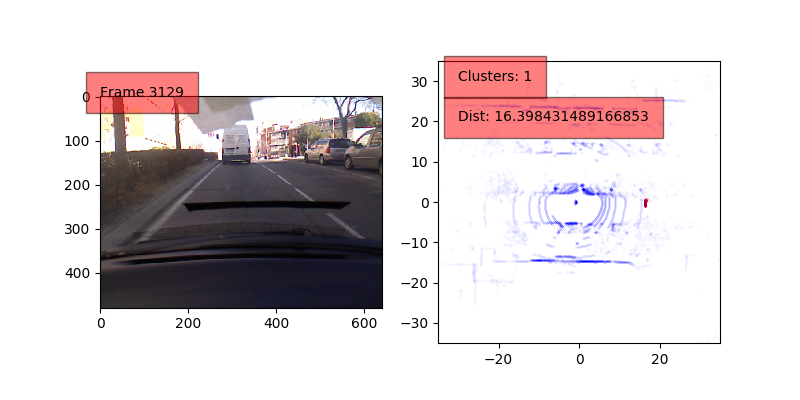

KeyboardInterrupt: 

In [34]:
import time

from_index = 3115

fig, axs = plt.subplots(1, 2, figsize=figsize)
columns = []
for index, row in df.iterrows():
    if from_index is not None and from_index <= index:
        if not (pd.isnull(row['snapshots_path']) or pd.isnull(row['pointclouds_path'])):
            plt_image(axs[0], index, os.path.join(SUBJECT_PATH, row['snapshots_path']))
            plt_lidar(axs[1], os.path.join(SUBJECT_PATH, row['pointclouds_path']), columns)
        fig.canvas.draw()